#Kuler Preference

###Summary
- 07/06/15
    - We finally implement user preference in a clustering analysis (kmeans).
    - Scale preference (normalize) -> come up with an integer for # of likes -> duplicate -> run kmeans

##Import modules

In [341]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import scipy as sp

# plotting
import matplotlib.pyplot as plt
import matplotlib.cm as pltcm
%matplotlib inline

##Load dataframes and ndarrays

In [342]:
df = pd.read_pickle('kuler_df')
df_ = pd.read_pickle('kuler_df_')
df_all = pd.read_pickle('kuler_df_all')
data_pair = np.load('kuler_data_pair.npy')
data_LabAll = np.load('kuler_data_LabAll.npy')

- Concatenate Likes to df_

In [343]:
df_['Likes']=df.Likes

##I. Feature scaling

In [344]:
df_.Likes.describe()

count     4931.000000
mean       224.492801
std        498.726783
min         62.000000
25%         78.000000
50%        108.000000
75%        188.000000
max      13707.000000
Name: Likes, dtype: float64

- Problem: "Likes" has a very long tail and the range of number of Likes is large.
- Possible solution: log transformation
    - natural log -> normalize to make the smallest value 0 (# of duplicates) -> round up to convert float to int

In [345]:
# create a new column for log-normalized likes
df_['Likes_norm'] = np.round(np.log(df_.Likes)-np.min(np.log(df_.Likes)))

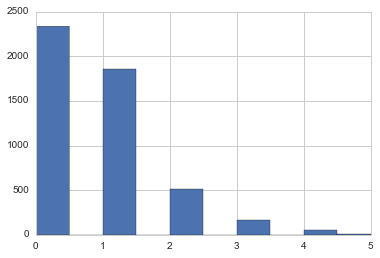

In [346]:
df_['Likes_norm'].hist()

####Plan
- loop over the rows with likes_norm > 0
- for each row, generate a DataFrame ([array,]*n_duplicate)
- concatenate (ignore_index=True)

###1. Find the row numbers to loop for

In [347]:
# the data is already sorted by the number of likes
# find the last row with non-zero norm-likes
row_max = int(df_[df_.Likes_norm==1][-1:].index[0])
print row_max

2603


###2. Create a duplicate DataFrame

In [370]:
# initialize
df_dup = DataFrame()
for i in range(row_max):
    # number of duplicate copies
    n_duplicate = df_.loc[i].Likes_norm
    # create duplicates for the corresponding row
    temp = DataFrame([df_.loc[i].values,]*n_duplicate)
    # concatenate the duplicates
    df_dup = pd.concat([df_dup,temp],ignore_index=True)

###3. Concatenate with the parent

In [371]:
# Name the columns
df_dup.columns = list(df_.columns)

In [372]:
# concatenate
df2 = DataFrame()
df2 = pd.concat([df_,df_dup],ignore_index=True)

In [373]:
# drop the last two columns (likes, norm_likes)
df2.drop(df2.columns[-2:], axis=1, inplace=True)

In [374]:
df2.tail()

,Lab1,Lab2,Lab3,Lab4,Lab5,L1,a1,b1,L2,a2,b2,L3,a3,b3,L4,a4,b4,L5,a5,b5
8542,LabColor (lab_l:36.0806 lab_a:6.7882 lab_b:-31...,LabColor (lab_l:75.6897 lab_a:-27.6518 lab_b:-...,LabColor (lab_l:91.7830 lab_a:-7.2667 lab_b:-4...,LabColor (lab_l:100.0000 lab_a:-0.0005 lab_b:-...,LabColor (lab_l:86.4167 lab_a:14.0420 lab_b:17...,36.080591,6.788230,-31.306032,75.689748,-27.651836,-2.942409,91.782976,-7.266719,-4.137015,99.999985,-0.000459,-0.008561,86.416740,14.041987,17.981608
8543,LabColor (lab_l:91.5280 lab_a:1.0845 lab_b:31....,LabColor (lab_l:64.8585 lab_a:-32.8457 lab_b:2...,LabColor (lab_l:27.1519 lab_a:39.5325 lab_b:-1...,LabColor (lab_l:14.4444 lab_a:22.7030 lab_b:-1...,LabColor (lab_l:6.1043 lab_a:10.3976 lab_b:-13...,91.527972,1.084520,31.726765,64.858533,-32.845677,2.992858,27.151875,39.532472,-14.462896,14.444435,22.702966,-19.381893,6.104281,10.397559,-13.916812
8544,LabColor (lab_l:31.8428 lab_a:10.8376 lab_b:-2...,LabColor (lab_l:17.3120 lab_a:20.8896 lab_b:-2...,LabColor (lab_l:63.5826 lab_a:-27.7722 lab_b:3...,LabColor (lab_l:92.6052 lab_a:-13.4234 lab_b:7...,LabColor (lab_l:36.2115 lab_a:4.7978 lab_b:-5....,31.842798,10.837605,-23.648820,17.311990,20.889555,-21.748113,63.582575,-27.772164,32.633110,92.605212,-13.423365,73.827720,36.211544,4.797832,-5.502343
8545,LabColor (lab_l:12.6141 lab_a:1.1219 lab_b:4.9...,LabColor (lab_l:82.0566 lab_a:-33.4460 lab_b:4...,LabColor (lab_l:61.5841 lab_a:-26.5078 lab_b:3...,LabColor (lab_l:32.0600 lab_a:-33.4687 lab_b:3...,LabColor (lab_l:95.4935 lab_a:-0.0004 lab_b:-0...,12.614084,1.121895,4.954221,82.056621,-33.446031,49.123127,61.584068,-26.507752,35.302418,32.059979,-33.468727,38.105975,95.493544,-0.000442,-0.008229
8546,LabColor (lab_l:62.3340 lab_a:-31.5141 lab_b:-...,LabColor (lab_l:74.9563 lab_a:-17.1141 lab_b:6...,LabColor (lab_l:92.4681 lab_a:1.3635 lab_b:7.0...,LabColor (lab_l:56.4738 lab_a:62.4523 lab_b:44...,LabColor (lab_l:43.3645 lab_a:55.2610 lab_b:41...,62.334001,-31.514076,-3.550759,74.956291,-17.114063,60.416013,92.468090,1.363467,7.027687,56.473847,62.452281,44.784061,43.364488,55.261039,41.611908


##II. Run kmeans

In [375]:
from sklearn import cluster
# run kmeans
def run_Kmeans(data,n_clusters,init='k-means++', n_init=10, max_iter=300):
    kmeans = cluster.KMeans(n_clusters=n_clusters,init=init,n_init=n_init,max_iter=max_iter)
    kmeans.fit(data)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    return labels, centroids, kmeans

In [376]:
def col_tuple2list(colormath_color):
    # extract values from colormath format
    a = colormath_color.get_value_tuple()[0]
    b = colormath_color.get_value_tuple()[1]
    c = colormath_color.get_value_tuple()[2]
    return [a,b,c]

- modified plotting function (plot_color_in_scheme, plot_Kmeans_collapsed)
    - generalized: now the first input is a df
    - <b>For plotting, LabColor (colormath) is needed in the df</b>

In [377]:
from colormath.color_objects import LabColor, sRGBColor # color format (sRGB, Lab)
from colormath.color_conversions import convert_color
from mpl_toolkits.mplot3d import Axes3D

# function that plots nth color (colorIdx) in mth theme (schemeIdx)
def plot_color_in_scheme(df_input,ax,colorIdx,schemeIdx,index1=0,index2=0):
    # viewpoint
    if index1 == 'a' and index2 == 'b':
        el = 90
        az = -90
    elif index1 == 'L' and index2 == 'a':
        el = 0
        az = 90
    elif index1 == 'L' and index2 == 'b':
        el = 0
        az = 180
    elif int(index1) == 0 and int(index2) == 0:
        el = None
        az = None
        
        # 1. conver Lab color to sRGB for assigning colors for the plot
        LabColor_cm = df_input['Lab'+str(colorIdx)][schemeIdx]
        sRGBColor_cm = convert_color(LabColor_cm,sRGBColor)

        # 2. convert this value to list for plotting
        sRGBColor_list = col_tuple2list(sRGBColor_cm)
        r = min(sRGBColor_list[0],1)
        g = min(sRGBColor_list[1],1)
        b = min(sRGBColor_list[2],1)
        color = np.array([[r,g,b],[0,0,0]])

        # 3. load the Lab coordinates
        L = df_input['L'+str(colorIdx)][schemeIdx]
        a = df_input['a'+str(colorIdx)][schemeIdx]
        b = df_input['b'+str(colorIdx)][schemeIdx]        

        # 4. draw each color (first: triangle, last: reversed triangle, in-betweens: circle)
        ax.scatter(a,b,L,c=color,s=250,marker='o')
            
    # view angle
    ax.view_init(elev=el,azim=az)

    ax.set_xlabel('a')
    ax.set_ylabel('b')
    ax.set_zlabel('L')
    ax.set_xlim3d(-128, 128)
    ax.set_ylim3d(-128, 128)
    ax.set_zlim3d(0, 100)

In [378]:
def plot_Kmeans_collapsed(df_input,labels,clusterIdx,figsize=10):
    # load indices
    indices = np.where(labels==clusterIdx)
    #print indices # print the schemeIdx's of this cluster

    # plotting
    len_x = figsize*1
    len_y = figsize*5
    fig = plt.figure(figsize=(len_y,len_x))    
    
    for k in range(5):
        colorIdx = k+1
        ax = fig.add_subplot(1,5,k+1,projection='3d')
        for j in range(len(indices[0])):
            schemeIdx = indices[0][j]
            plot_color_in_scheme(df_input,ax,colorIdx,schemeIdx)

- df needs to be sliced for kmeans
    - kmeans do not need LabColor (colormath) input

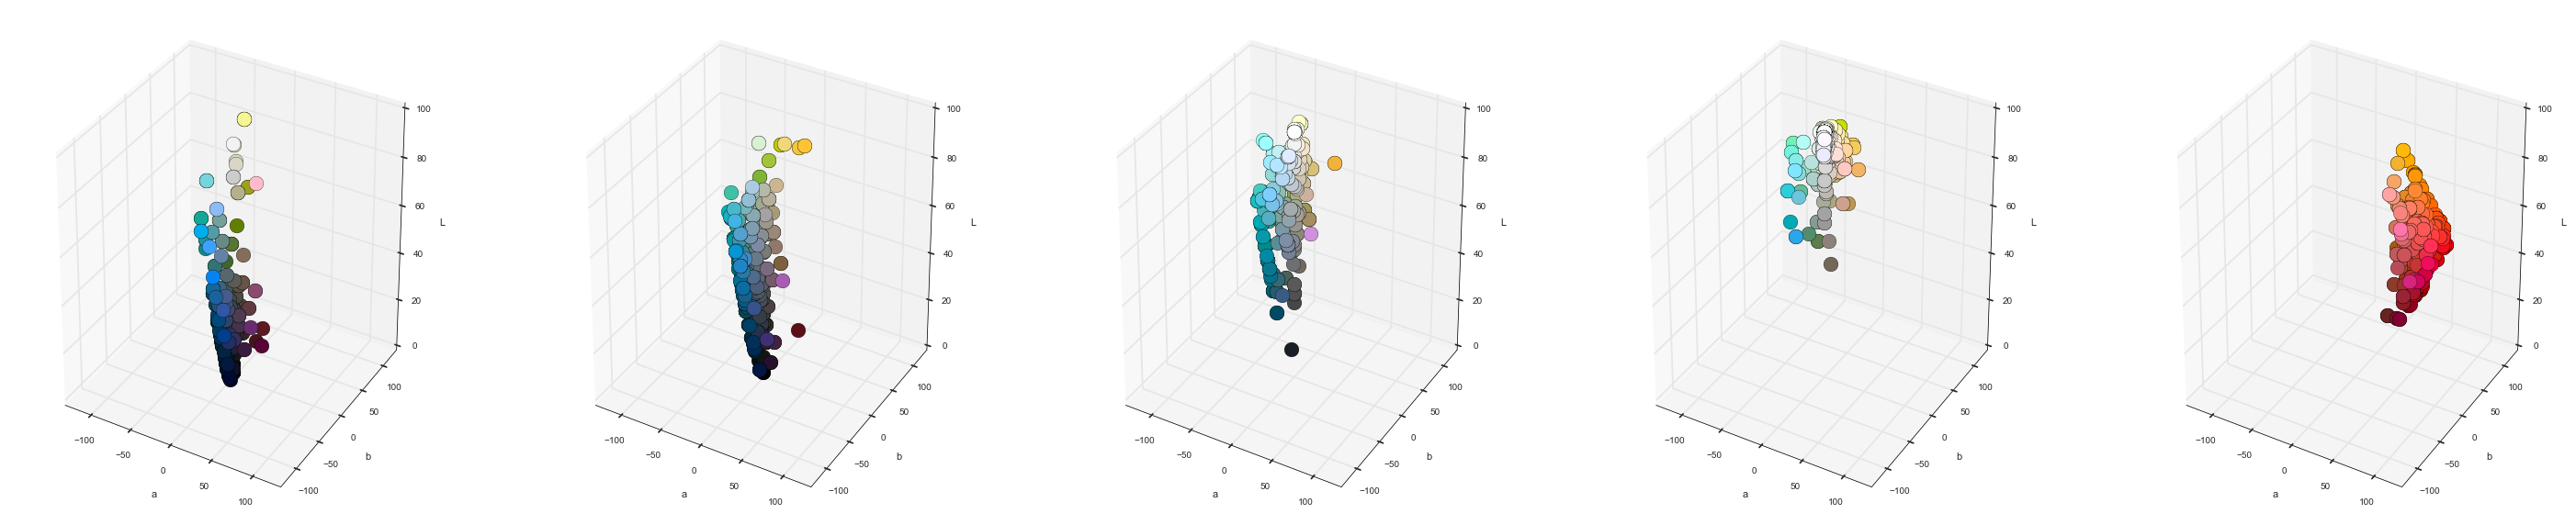

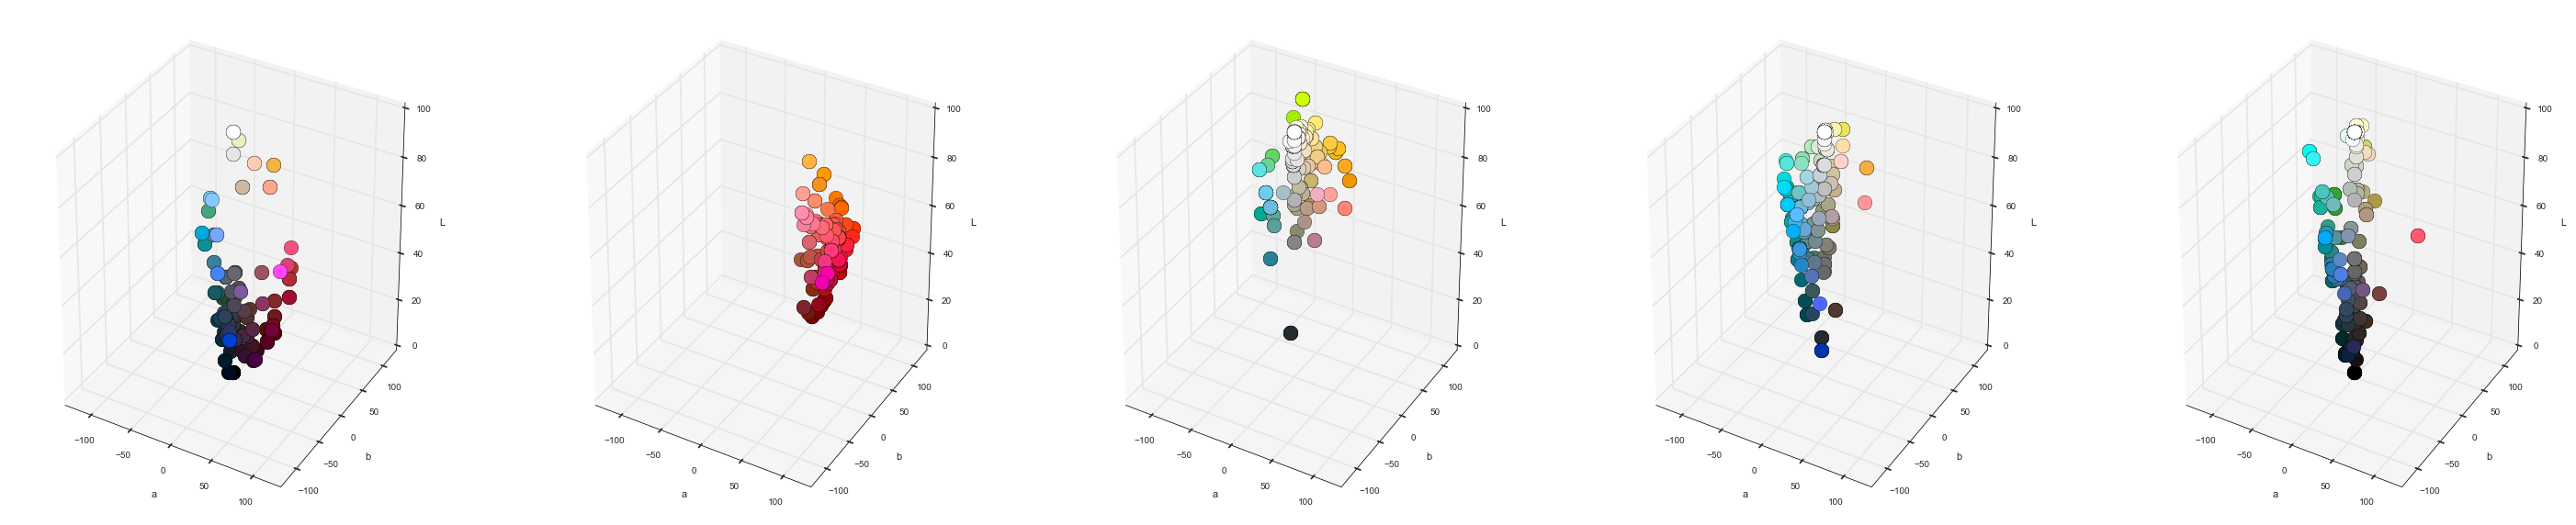

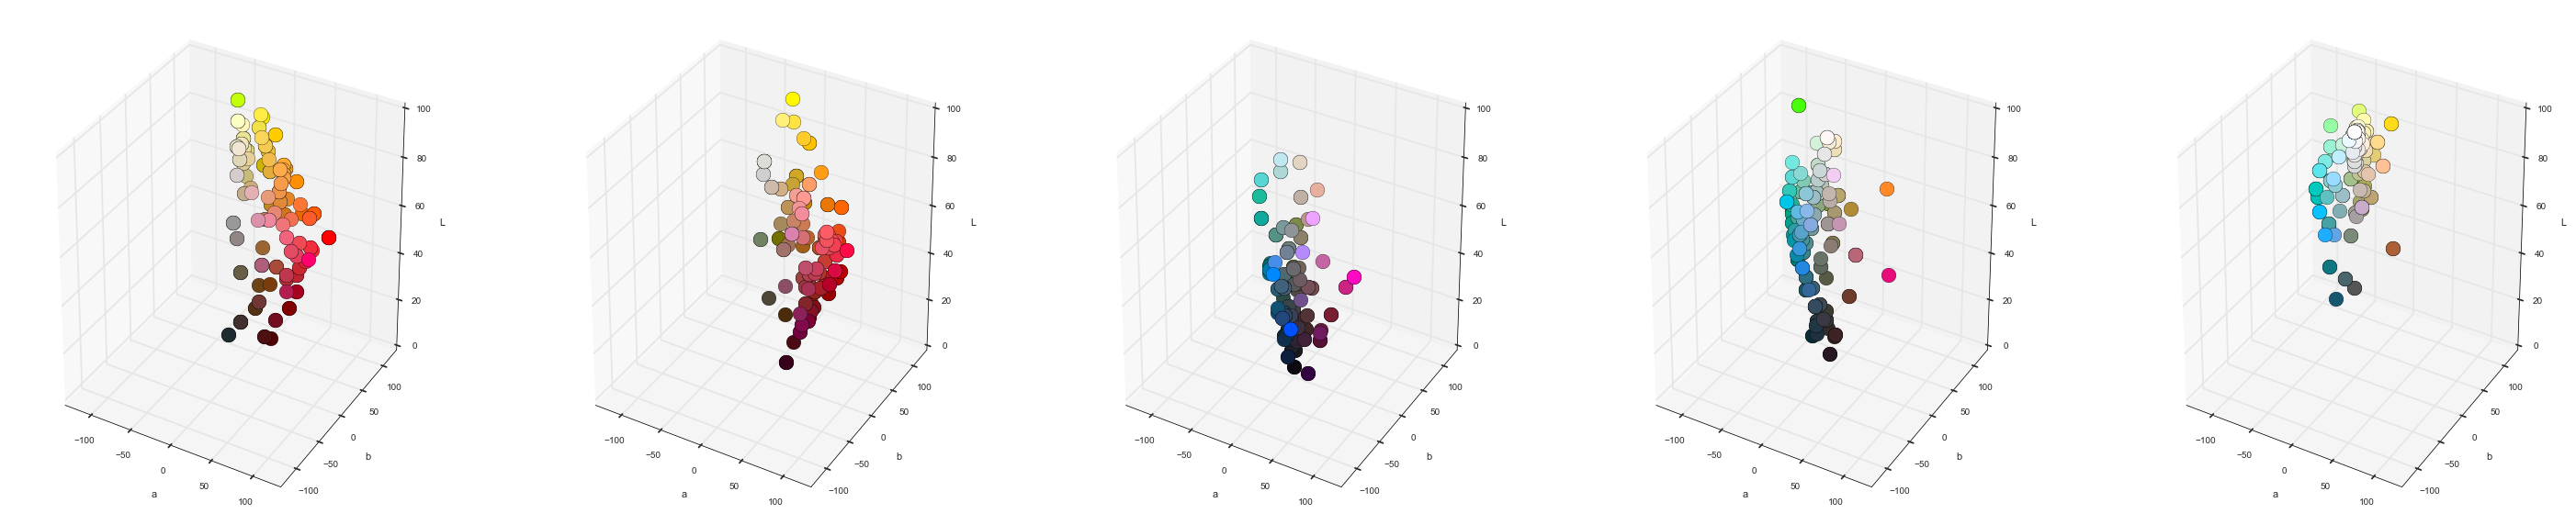

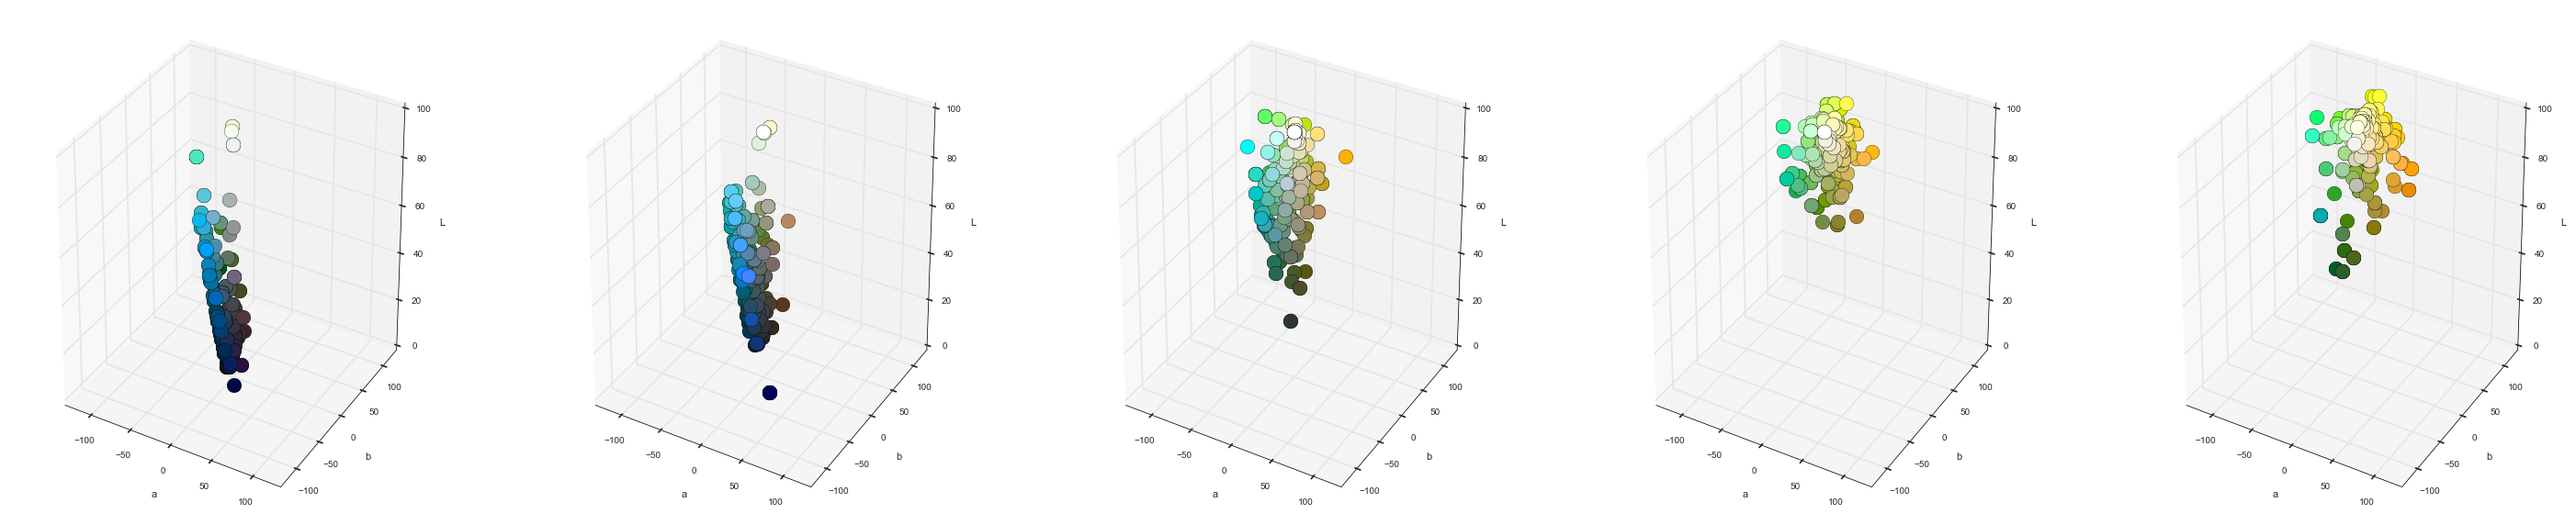

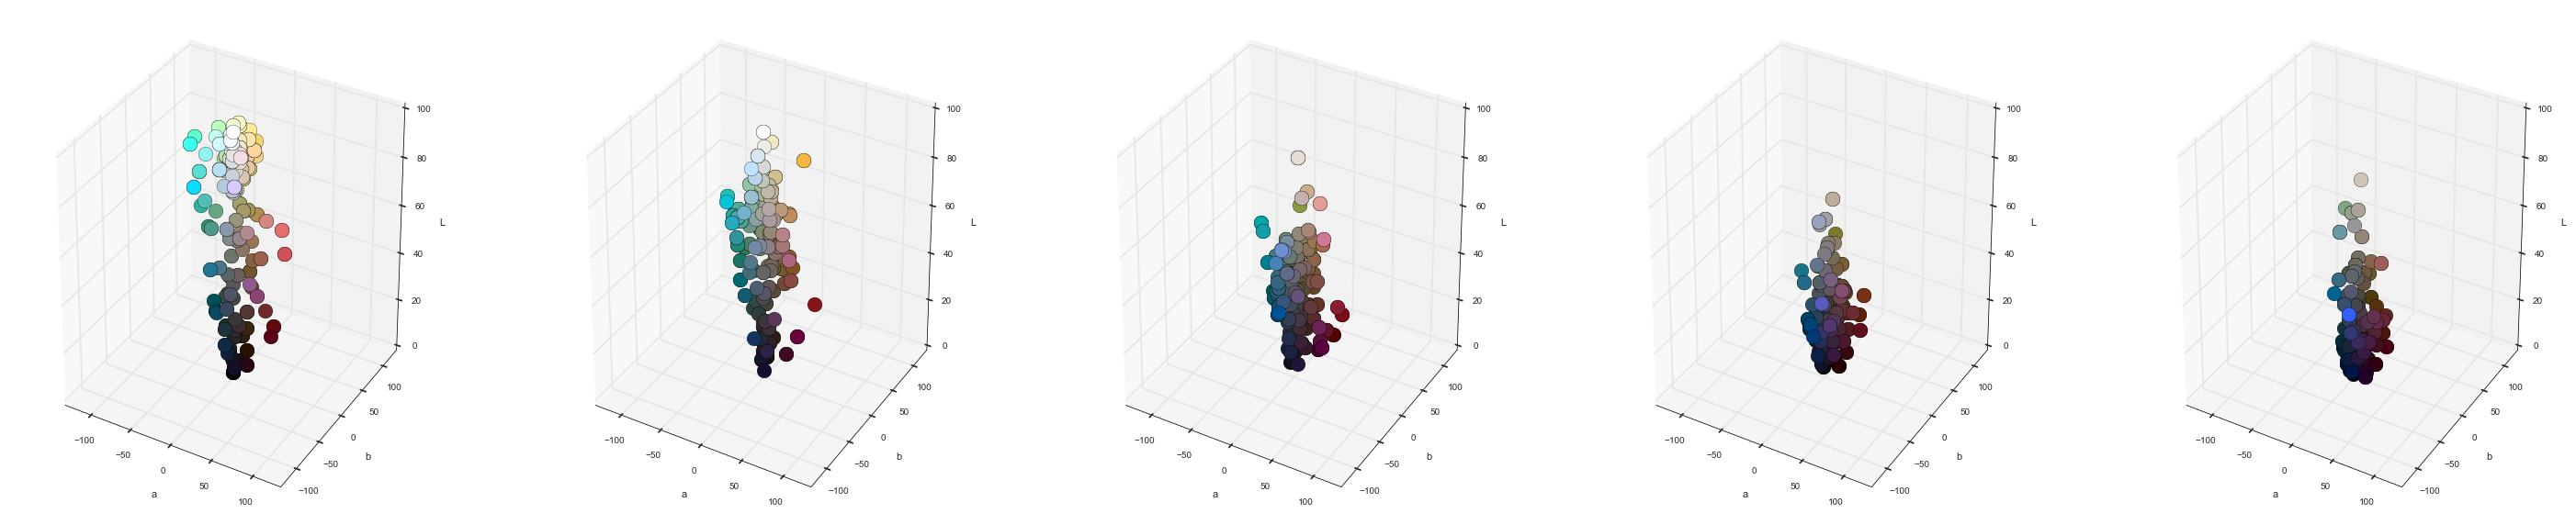

In [392]:
k = 25
df_kmeans = df2.ix[:,6:]
labels, centroids, kmeans = run_Kmeans(df_kmeans.values,30)
for i in range(5):
    plot_Kmeans_collapsed(df2,labels,i)